In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

df = pd.read_csv("/content/Q1Data.csv")
df = df.sample(frac=0.6, random_state=42)

X = df.iloc[:, 1:-3].values
y = df['Genus'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=88)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3453, 20)
(3453,)
(864, 20)
(864,)


In [13]:
#Part 2: Scratch Knn

def euclideanDistance(x1, x2):
    diffInsq = np.square(x1 - x2)
    sumDiffSq = np.sum(diffInsq)
    finalDist = np.sqrt(sumDiffSq)
    return finalDist


def calacAccuracy(y_test,predictions):
    correct_count = 0

    for i in range(len(y_test)):
        if predictions[i] == y_test[i]:
            correct_count += 1

    accuracy = correct_count / len(y_test)
    return accuracy


class KNN:
    def __init__(self,X_train,y_train, k):
        self.k = k
        self.X_train = X_train
        self.y_train = y_train

    def getPredictionList(self, X_test):
        predictionList = []
        for x_test in X_test:

            distances = []
            for x_train in self.X_train:
              distances.append(euclideanDistance(x_test, x_train))

            indicesOfNearPoints = np.argsort(distances)[:self.k]

            k_nearest_labels = []
            for i in indicesOfNearPoints:
                k_nearest_labels.append(self.y_train[i])

            most_common = Counter(k_nearest_labels).most_common()
            predictionList.append(most_common[0][0])

        return predictionList



ks = list(range(1, 51))
Accuracies = []

for k in ks:
    knnObj = KNN(X_train, y_train,k)
    predictions = knnObj.getPredictionList(X_test)
    accuracy = calacAccuracy(y_test,predictions)
    Accuracies.append(accuracy)





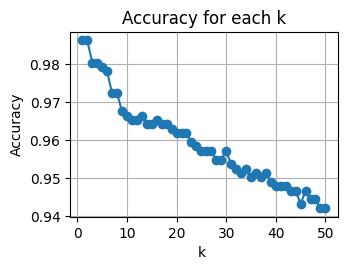

In [14]:
plt.subplot(2, 2, 4)
plt.plot(ks, Accuracies, marker='o', label='Scratch')
plt.title('Accuracy for each k')
plt.xlabel('k ')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

K gives best accuracy for values 1 and 2 . after that accuracy steadily decreases

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter



# Part 3b: kNN using scikit-learn
# k_values = list(range(1, 1001))
k_values = list(range(1, 51))
knn_test_accuracies = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    knn_predictions = knn_classifier.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    knn_test_accuracies.append(knn_accuracy)

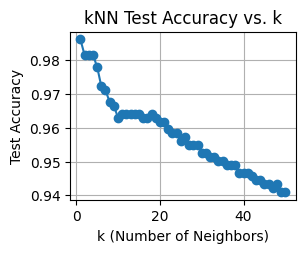

In [16]:
# Plot for kNN
plt.subplot(2, 2, 2)
plt.plot(k_values, knn_test_accuracies, marker='o')
plt.title('kNN Test Accuracy vs. k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Test Accuracy')
plt.grid(True)

0.6597222222222222
0.75
0.8101851851851852
0.8356481481481481
0.8518518518518519
0.8726851851851852
0.8819444444444444
0.8865740740740741
0.8726851851851852
0.8796296296296297
0.8726851851851852
0.8634259259259259
0.8819444444444444
0.8888888888888888
0.8819444444444444
0.8796296296296297


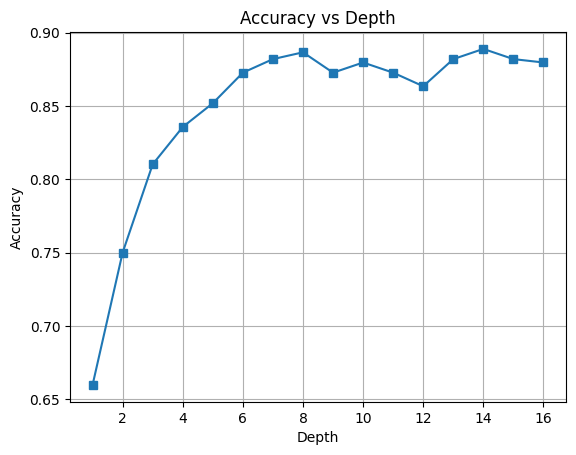

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import random


class Node:
    def __init__(self, **kwargs):
        self.feature = kwargs.get('feature')
        self.threshold = kwargs.get('threshold')
        self.left = kwargs.get('left')
        self.right = kwargs.get('right')
        self.value = kwargs.get('value')

class DecisionTree:
    def __init__(self,maxDepth,X,y):
        self.maxDepth = maxDepth
        self.root=None
        _, self.n_features = X.shape
        self.root = self._appendNextNode(X, y)




    def _getBestSplit(self, X, y):
        feautureIndexes = random.sample(range(self.n_features), self.n_features)
        best_gain = 0
        split_idx, split_threshold = None, None

        for featureIndex in feautureIndexes:
            X_column = []
            for row in X:
                X_column.append(row[featureIndex])
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self._informationGain(y, X_column, thr)

                split_idx = featureIndex if gain > best_gain else split_idx
                split_threshold = thr if gain > best_gain else split_threshold
                best_gain = max(gain, best_gain)

        return split_idx, split_threshold


    def _splitDataset(self,X, y, bestFeature, bestThresh):
        selected_feature_values = []

        for row in X:
            selected_feature_values.append(row[bestFeature])

        leftIndexes = []
        rightIndexes = []
        for idx, val in enumerate(selected_feature_values):
            if val <= bestThresh:
                leftIndexes.append(idx)
            else:
                rightIndexes.append(idx)

        leftSideX = X[leftIndexes, :]
        leftSidey = y[leftIndexes]

        rightSideX = X[rightIndexes, :]
        rightSidey = y[rightIndexes]

        return leftSideX, leftSidey, rightSideX, rightSidey


    def _appendNextNode(self, X, y, depth=0):
        n_samples, _ = X.shape
        isOnlyOneYLabel = len(np.unique(y)) == 1

        if (depth>=self.maxDepth or isOnlyOneYLabel or n_samples<5):
            leaf_value = self.mostCommonYLabel(y)
            node_data = {
                'value': leaf_value,
            }
            node = Node(**node_data)
            return node
            # return Node(value=leaf_value)

        pair_variable = self._getBestSplit(X, y)
        bestFeature = pair_variable[0]
        bestThresh = pair_variable[1]


        leftSideX, leftSidey, rightSideX, rightSidey = self._splitDataset(X, y, bestFeature, bestThresh)

        left = self._appendNextNode(leftSideX,leftSidey , depth+1)
        right = self._appendNextNode(rightSideX, rightSidey, depth+1)

        node_data = {
            'feature': bestFeature,
            'threshold': bestThresh,
            'left': left,
            'right': right,
        }
        node = Node(**node_data)
        return node
        # return Node(bestFeature, bestThresh, left, right)


    def _entropCalc(self, y):
        freqOfEachLabel = np.bincount(y)
        totalLabels= len(y)
        probabilities = freqOfEachLabel / totalLabels
        entropy = 0.0
        for i in range(len(probabilities)):
          p = probabilities[i]
          if p > 0:
              entropy -= p * np.log(p)
        return entropy


    def _calculateChildEntropy(self, y, leftIndexes, rightIndexes):
        totalSamples = len(y)
        numSamplesLeft = len(leftIndexes)
        numSamplesRight = len(rightIndexes)
        entropyLeft = self._entropCalc(y[leftIndexes])
        entropyRight = self._entropCalc(y[rightIndexes])
        weightedEntropyLeft = (numSamplesLeft / totalSamples) * entropyLeft
        weightedEntropyRight = (numSamplesRight / totalSamples) * entropyRight
        childEntropy = weightedEntropyLeft + weightedEntropyRight
        return childEntropy



    def _informationGain(self, y, X_column, threshold):
        information_gain = self._entropCalc(y)
        leftIndexes = []
        rightIndexes = []
        for idx, val in enumerate(X_column):
            if val <= threshold:
                leftIndexes.append(idx)
            else:
                rightIndexes.append(idx)

        if len(leftIndexes) == 0:
            return 0
        if len(rightIndexes) == 0:
            return 0
        information_gain -= self._calculateChildEntropy(y, leftIndexes, rightIndexes)


        return information_gain


    def mostCommonYLabel(self, y):
        unique_elements, counts = np.unique(y, return_counts=True)
        return unique_elements[np.argmax(counts)]

    def predict(self, X):
        predictions = []
        for x in X:
            current_node = self.root
            while current_node.value is None:
                if x[current_node.feature] <= current_node.threshold:
                    current_node = current_node.left
                else:
                    current_node = current_node.right
            predictions.append(current_node.value)
        return np.array(predictions)

X = df.iloc[:, 1:7].values
y = df['Genus'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.3, random_state=88)


accuracies1 = []
for depth in range(1,17):
    dtObj = DecisionTree(depth,X_train, y_train)
    predictions = dtObj.predict(X_test)

    accuracy = np.mean(predictions == y_test)
    accuracies1.append(accuracy)
    print(accuracy)

# Plotting
numbers = [i for i in range(1, 17)]
plt.plot(numbers, accuracies1, marker='s')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Depth')

plt.grid(True)


Observation : There is no significant increase in accuracy beyond Depth 6, So the optimum depth is 6 to avoid overfitting.

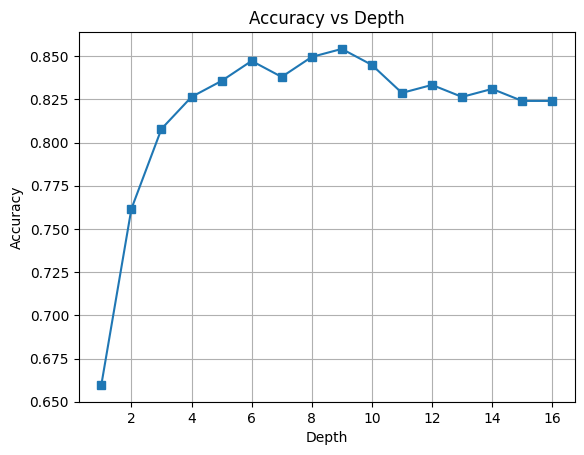

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
accuracies2 = []
for depth in range(1,17):
    predictions = DecisionTreeClassifier(max_depth=depth, random_state=88).fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracies2.append(accuracy)

numbers = [i for i in range(1, 17)]
plt.plot(numbers, accuracies2, marker='s')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Depth')
plt.grid(True)

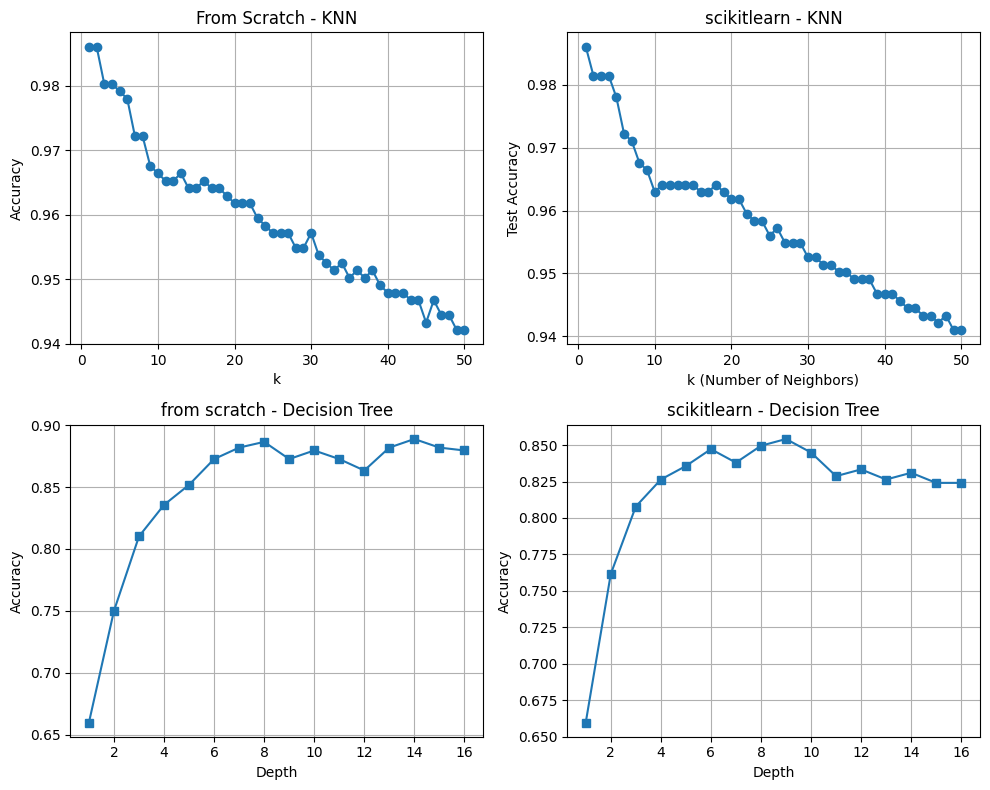

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(ks, Accuracies, marker='o', label='Scratch')
axs[0, 0].set_title('From Scratch - KNN')
axs[0, 0].set_xlabel('k')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].grid(True)

axs[0, 1].plot(k_values, knn_test_accuracies, marker='o')
axs[0, 1].set_title('scikitlearn - KNN')
axs[0, 1].set_xlabel('k (Number of Neighbors)')
axs[0, 1].set_ylabel('Test Accuracy')
axs[0, 1].grid(True)

numbers = [i for i in range(1, 17)]
axs[1, 0].plot(numbers, accuracies1, marker='s')
axs[1, 0].set_xlabel('Depth')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_title('from scratch - Decision Tree')
axs[1, 0].grid(True)

numbers = [i for i in range(1, 17)]
axs[1, 1].plot(numbers, accuracies2, marker='s')
axs[1, 1].set_xlabel('Depth')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('scikitlearn - Decision Tree')
axs[1, 1].grid(True)

plt.tight_layout()

plt.show()

THe model built from scratch performs almost similar result as scikitlearn one, but still there are minimal errors as scikitlearn is one of the most optimized library out there